# 灰度处理

对于一张图片，当我们只关心其边界的时候，单通道的图片已经足够提供检测出边界的信息。所以我们可以将R、G、B的3通道图片乃至更高维的高光谱遥感图像进行灰度化。灰度化实际上是一种降维操作，它减少了冗余数据从而降低了计算开销。以下是对RGB图片灰度化的方法：

In [ ]:
# 灰度化
import numpy as np
import matplotlib.pyplot as plt
import cv2
def gray(img_path):
	"""
	计算公式：
	Gray(i,j) = [R(i,j) + G(i,j) + B(i,j)] / 3
	or :
	Gray(i,j) = 0.299 * R(i,j) + 0.587 * G(i,j) + 0.114 * B(i,j)
	"""
	
	# 读取图片
	img = plt.imread(img_path)
	# BGR 转换成 RGB 格式
	img_rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
	# 灰度化
	img_gray = np.dot(img_rgb[...,:3],[0.299,0.587,0.114])
	return img_gray


# 高斯模糊

高斯模糊实际上是对灰度化后的图像去噪。从数学的角度来看，图像的高斯模糊过程就是图像与正态分布做卷积。进行高斯滤波之前，需要先得到一个高斯滤波器（kernel）。如何得到一个高斯滤波器呢？其实就是将高斯函数离散化，将滤波器中对应的横纵坐标索引代入高斯函数，即可得到对应的值。不同尺寸的滤波器，得到的值也不同，下面是二维高斯函数与 (2k+1)x(2k+1) 滤波器的计算公式 :

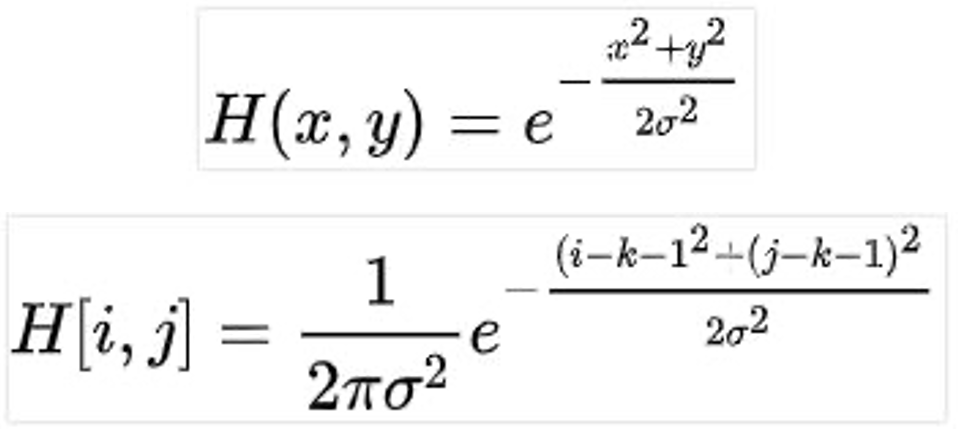

In [69]:
# 去除噪音 - 使用 5x5 的高斯滤波器
import math
def smooth(img_gray):
	# 生成高斯滤波器
	"""
	要生成一个 (2k+1)x(2k+1) 的高斯滤波器，滤波器的各个元素计算公式如下：
	H[i, j] = (1/(2*pi*sigma**2))*exp(-1/2*sigma**2((i-k-1)**2 + (j-k-1)**2))
	"""
	sigma = 1.4
	gaussian_sum = 0
	gaussian_kernel = np.zeros((5,5))
	for i in range(5):
		for j in range(5):
			gaussian_kernel[i,j] = np.exp((-np.square(i-3)-np.square(j-3))/(2*np.square(sigma)))/(2*math.pi*np.square(sigma))
			gaussian_sum += gaussian_kernel[i,j]
	# 归一化处理
	gaussian_kernel  /= gaussian_sum
	
	# 高斯滤波
	H,W = img_gray.shape
	img_gray_denoised = np.zeros((H-5,W-5))
	for i in range(H-5):
		for j in range(W-5):
			img_gray_denoised[i,j] = np.sum(img_gray[i:i+5,j:j+5]*gaussian_kernel)
	return img_gray_denoised
	
	


# 图像梯度、梯度幅值、梯度方向计算

这个步骤的重要性不言而喻。直观感受上来讲我们知道一个图像上处于边界附近位置的像素值变化较大。而处于物体内部位置的像素值大多相近。这样我们可以计算当前像素与其附近像素的像素值的差值判断该像素处于物体内部还是边界。这个差值我们称为图像梯度。梯度幅值、梯度方向由图像梯度计算而来。
具体而言，我们用一阶导数来计算梯度：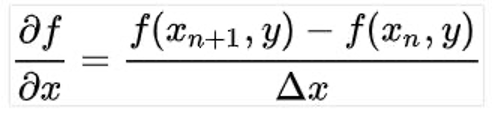

对于上式，实际操作时就是用当前像素的下一个像素减去当前像素。此时$\Delta x=1$;
梯度包含x方向的梯度与y方向的梯度。它们是两个向量。梯度幅值是这两个向量的向量和：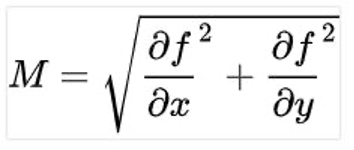

既然梯度幅值是一个向量，那么我们需要计算它的方向：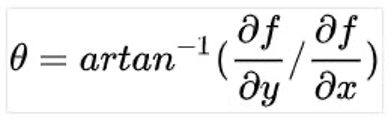


In [68]:
def gradients(img_gray_denoised):
    """
	输入：高斯模糊之后的图像 \n
	输出： dx: x方向的梯度 
           dy: y方向梯度 
           M: 梯度幅值（两个矢量和的模长） \n
           theta: 梯度方向
	"""
    H,W = img_gray_denoised.shape
    dx = np.zeros((H-1,W-1))
    dy = np.zeros((H-1,W-1))
    M = np.zeros((H-1,W-1))
    theta = np.zeros((H-1,W-1))

    for i in range(H-1):
        for j in range(W-1):
            dy[i,j] = img_gray_denoised[i+1,j] - img_gray_denoised[i,j]
            dx[i,j] = img_gray_denoised[i,j+1] - img_gray_denoised[i,j]
            M[i,j] = np.sqrt(np.square(dx[i,j])+np.square(dy[i,j]))
            theta[i,j] = math.atan(dy[i,j]/(dx[i,j]+0.000000001))
    return dx,dy,M,theta

# 非极大值抑制

通过计算梯度（这里以一个像素为单位，计算相邻像素之间的梯度差值），一共有四种情况。

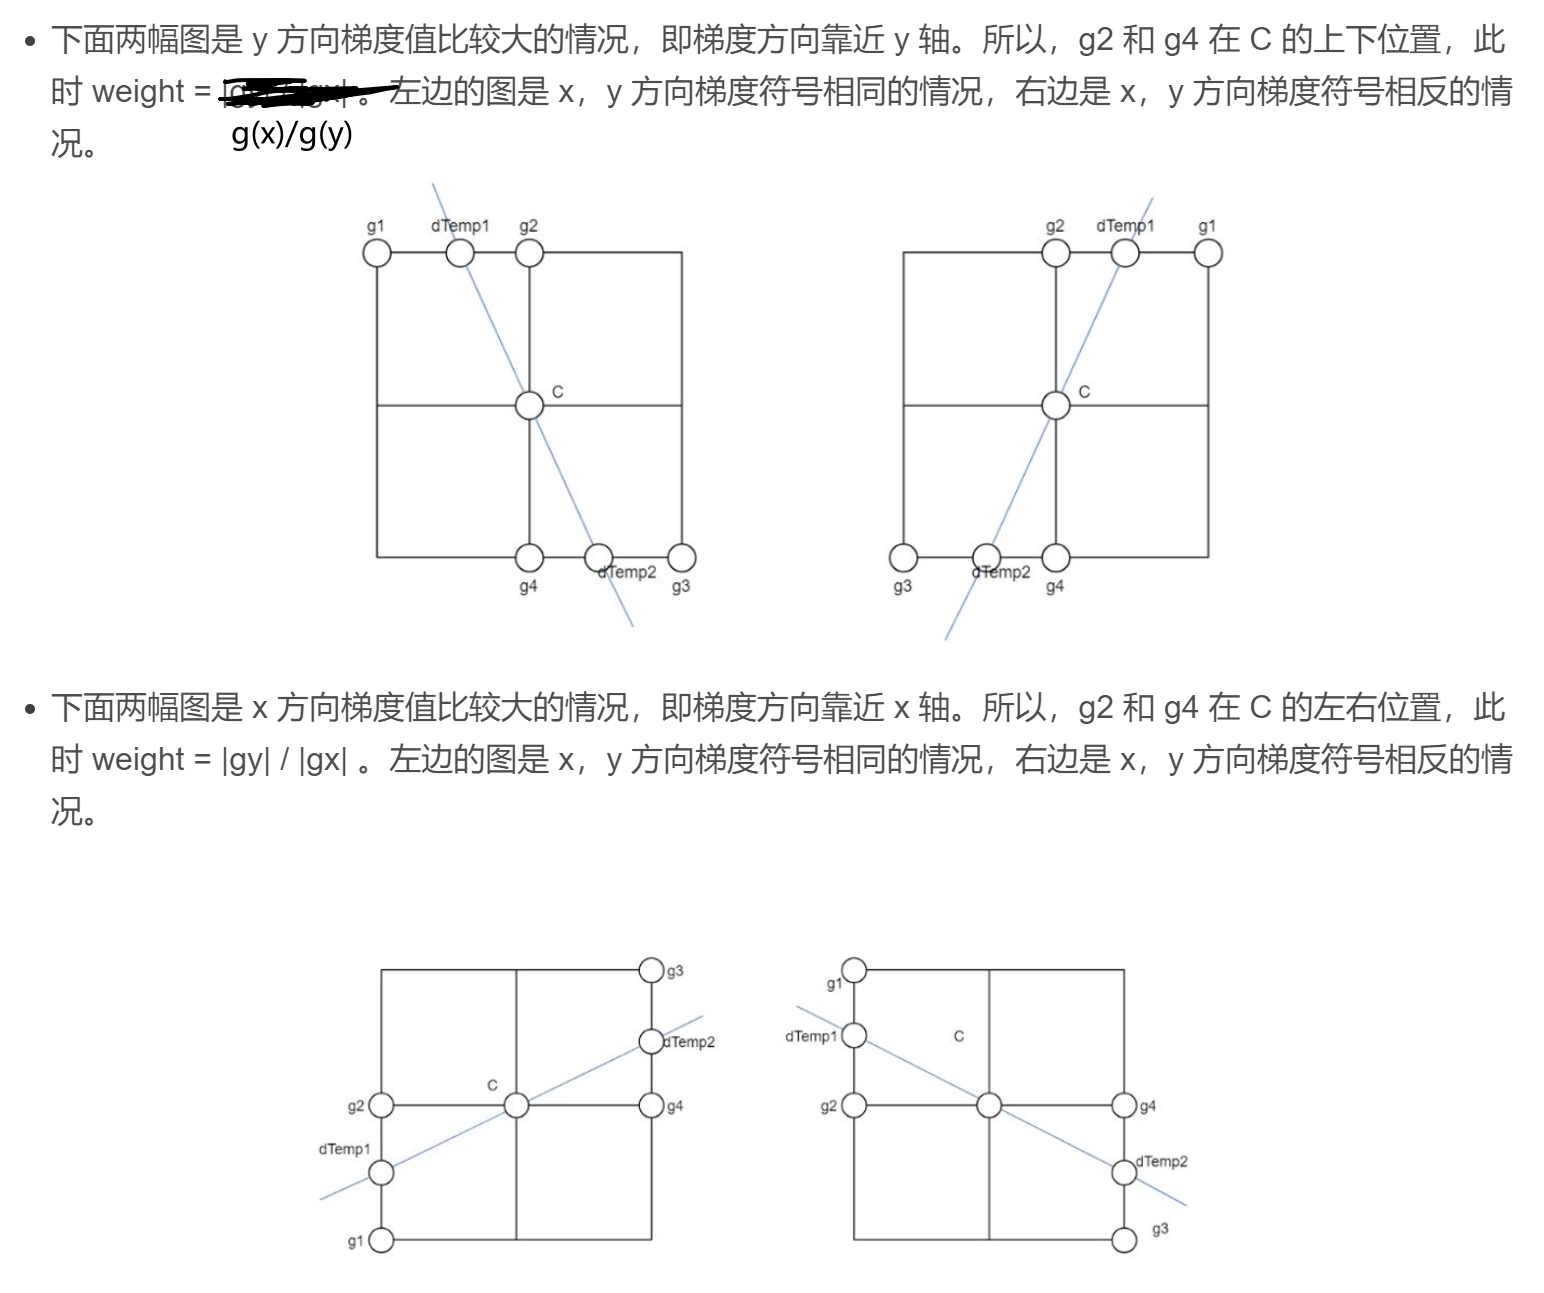

In [73]:
def NMS(M,dx,dy):
    d = np.copy(M)
    H,W = M.shape
    NMS = np.copy(d)
    NMS[0,:] = NMS[H-1,:] = NMS[:,0] = NMS[:,W-1] = 0
    for i in range(1,H-1):
        for j in range(1,W-1):
            if M[i,j] == 0:
                NMS[i,j] = 0
            else:
                gradX = dx[i,j]
                gradY = dy[i,j]
                gradTemp = d[i,j]

                if(np.abs(gradX)>np.abs(gradY)):
                    weight = np.abs(gradY) / np.abs(gradX)
                    g2 = d[i,j-1]
                    g4 = d[i,j+1]
                    if gradX * gradY > 0:
                        g3 = d[i+1,j+1]
                        g1 = d[i-1,j-1]
                    else:
                        g3 = d[i-1,j+1]
                        g1 = d[i+1,j-1]
                else:
                    weight = np.abs(gradX)/np.abs(gradY)
                    g2 = d[i-1,j]
                    g4 = d[i+1,j]
                    if gradX * gradY > 0:
                        g3 = d[i+1,j+1]
                        g1 = d[i-1,j-1]
                    else:
                        g3 = d[i+1,j-1]
                        g1 = d[i-1,j+1]
                gradTemp1 = weight * g1 + (1-weight) * g2
                gradTemp2 = weight * g3 + (1-weight) * g4
                if gradTemp >= gradTemp1 and gradTemp >= gradTemp2:
                    NMS[i,j] = gradTemp
                else:
                    NMS[i,j] = 0
    return NMS

# 双阈值检测

高于阈值的即为边缘；低于阈值的即为非边缘；处于二者之间的，还要判断是否有可靠性边缘连接

In [83]:
def double_threshold(NMS):
    H,W = NMS.shape
    DT = np.zeros((H,W))
    TL = 0.1 * np.max(NMS)
    TH = 0.3 * np.max(NMS)

    for i in range(1,H-1):
        for j in range(1,W-1):
            if (NMS[i,j]<TL):
                DT[i,j] = 0
            elif (NMS[i,j]>TH):
                DT[i,j] = 1
            elif (NMS[i-1, j-1:j+2] < TH).any() or (NMS[i+1, j-1:j+2]).any() or (NMS[i, [j-1, j+1]] < TH).any():
                DT[i,j] = 1
    return DT


In [ ]:
image = cv2.imread('test.jpg')
gray_image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)


array([[153, 156, 113, ..., 199, 199, 199],
       [146, 153, 115, ..., 199, 199, 199],
       [113, 110,  55, ..., 199, 199, 199],
       ...,
       [ 13,  13,  27, ...,  49,  40,  36],
       [ 29,  23,  19, ...,  40,  37,  37],
       [ 16,  22,  17, ...,  36,  37,  38]], dtype=uint8)

In [86]:
import cv2 #导入opencv库
 #读取图片
img = cv2.imread("test.jpg")
#进行canny边缘检测
edge = cv2.Canny(img,50,150)
#保存结果
cv2.imwrite('test_canny_official.jpg',edge)


True

In [39]:
gray_image=gray('test.jpg')
smoothed_image = smooth(gray_image)

In [63]:
dx,dy,M,theta = gradients(smoothed_image)

In [75]:
after = NMS(M,dx,dy)

In [84]:
last = double_threshold(after)

In [87]:
# 转换数据格式为 0-255 并保存
final_output = (last * 255).astype(np.uint8)
cv2.imwrite("test_canny_myself.jpg", final_output)
print("已保存到 test_canny_myself.jpg")

已保存到 test_canny_myself.jpg


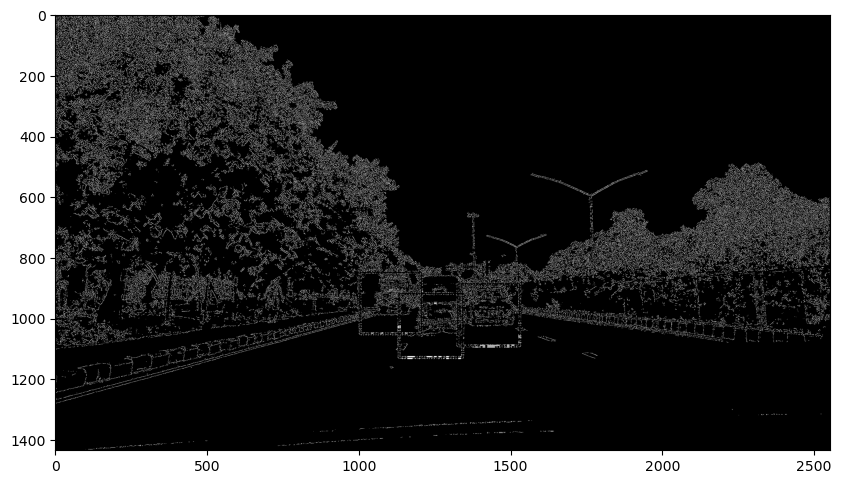

In [85]:
plt.figure(figsize=(10,10))
plt.imshow(last,cmap='gray')
plt.show()

In [45]:
smoothed_image.shape

(1435, 2555)

In [44]:
smoothed_image[:5]

array([[ 95.32614379,  99.92515431, 118.14762764, ..., 208.032     ,
        208.032     , 208.032     ],
       [ 91.05211977,  87.19171403,  96.76168556, ..., 208.032     ,
        208.032     , 208.032     ],
       [115.70216202, 105.95525689, 101.90265535, ..., 208.032     ,
        208.032     , 208.032     ],
       [145.59232409, 135.02749743, 120.1466929 , ..., 208.032     ,
        208.032     , 208.032     ],
       [172.68685171, 165.76817581, 146.94647278, ..., 208.032     ,
        208.032     , 208.032     ]])

In [55]:
smoothed_image[1,1],smoothed_image[0,1],smoothed_image[1,2],smoothed_image[2,1]

(87.19171403434474, 99.92515430516004, 96.76168556330586, 105.95525688518941)

In [56]:
smoothed_image[2,1]-smoothed_image[1,1]

18.763542850844672

In [64]:
dx[1,1],dy[1,1],dx[1,1]/dy[1,1]

(18.763542850844672, 9.56997152896112, 1.9606686178805772)

In [65]:
theta[1,1]

1.0991568767393198

In [66]:
math.tan(theta[1,1])

1.9606686176756998